# Week 2: Two-View Reconstruction
## CS436 Computer Vision Fundamentals - 3D Scene Reconstruction Project

**Student Name:** Muhammad Arslan Rafiq, Talha Nasir 
**Deliverable:** Essential Matrix Estimation, Pose Recovery & Point Cloud Generation

In [ ]:
image_dir = r"c:\Users\ASUS\Desktop\PROJECT\CV\data\frames"


## Step 1: Environment Setup & Library Imports

In [4]:
# === Week 2: Two-View Reconstruction ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os
from glob import glob
from PIL import Image
import piexif

## Step 2: Loading Image Pair for Reconstruction

In [5]:
# === Load two frames for reconstruction ===
frames_dir = r"C:\Users\ASUS\Desktop\PROJECT\CV\data\frames"
image_paths = sorted(glob(os.path.join(frames_dir, "*.jpg")))

# Pick any two (you can change indices later)
img1_path = image_paths[10]
img2_path = image_paths[11]

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

assert img1 is not None and img2 is not None, "Error loading selected frames."
print(f"Loaded:\n  {os.path.basename(img1_path)}\n  {os.path.basename(img2_path)}")

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


Loaded:
  frame_0011.jpg
  frame_0012.jpg


## Step 3: Define Camera Intrinsic Matrix (K)

In [ ]:
# === Define Camera Intrinsic Matrix K ===

h, w = gray1.shape
print(f"Image size: {w}×{h}")

# ---- OPTION A: Simplified (Manual) ----
# fx = fy = image width, cx, cy = image center
K_simple = np.array([
    [w,   0, w/2],
    [0,   w, h/2],
    [0,   0,   1 ]
], dtype=float)
print("K_simple =\n", K_simple)

# ---- OPTION B: EXIF-based (Real) ----
# Read focal length from EXIF (in mm) and estimate sensor width
try:
    exif_dict = piexif.load(img1_path)
    focal_length_mm = exif_dict['Exif'][piexif.ExifIFD.FocalLength][0] / \
                      exif_dict['Exif'][piexif.ExifIFD.FocalLength][1]
except Exception as e:
    print("EXIF focal length not found, using default 6.9 from my Phone Metadata.")
    focal_length_mm = 6.9

sensor_width_mm = 9.8  # Pixel 8 Pro main sensor
fx_real = (focal_length_mm / sensor_width_mm) * w
fy_real = fx_real
K_real = np.array([
    [fx_real, 0, w/2],
    [0, fx_real, h/2],
    [0, 0, 1]
])
print(f"EXIF focal length: {focal_length_mm:.2f} mm")
print("K_real =\n", K_real)

# === Choosing which to use ===
# K = K_simple  
K = K_real


Image size: 1080×1920
K_simple =
 [[1.08e+03 0.00e+00 5.40e+02]
 [0.00e+00 1.08e+03 9.60e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
EXIF focal length not found, using default 6. from my Phone Metadata.
EXIF focal length: 6.90 mm
K_real =
 [[760.40816327   0.         540.        ]
 [  0.         760.40816327 960.        ]
 [  0.           0.           1.        ]]


## Step 4: Feature Detection & Matching (SIFT + Lowe's Ratio Test)

Good matches: 396


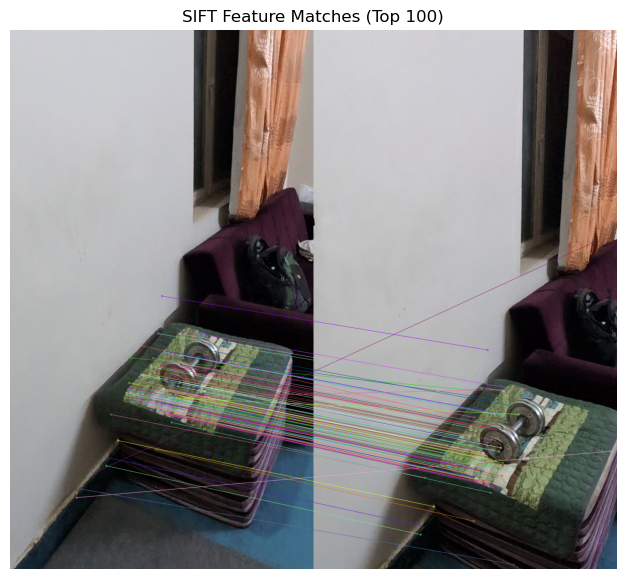

In [7]:
# === Detect and match SIFT features ===
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

# Lowe’s ratio test
good = [m for m, n in matches if m.distance < 0.75 * n.distance]
print(f"Good matches: {len(good)}")

# Visualize matches
match_vis = cv2.drawMatches(img1, kp1, img2, kp2, good[:100], None,
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,7))
plt.imshow(cv2.cvtColor(match_vis, cv2.COLOR_BGR2RGB))
plt.title("SIFT Feature Matches (Top 100)")
plt.axis("off")
plt.show()


## Step 5: Essential Matrix Estimation & Pose Recovery

In [8]:
# === Estimate Essential Matrix and recover pose ===

pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
print("Essential Matrix E:\n", E)

# Recover relative rotation R and translation t
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)
print("Recovered Rotation R:\n", R)
print("Recovered Translation t (normalized):\n", t.T)


Essential Matrix E:
 [[ 0.04774278 -0.02237609 -0.69669991]
 [ 0.07730282 -0.01507323  0.11402729]
 [ 0.68457686 -0.15003285  0.03832337]]
Recovered Rotation R:
 [[ 0.99570104 -0.06045687  0.07017415]
 [ 0.05365829  0.99402782  0.09502354]
 [-0.07549988 -0.09084961  0.99299855]]
Recovered Translation t (normalized):
 [[ 0.15381267  0.9806068  -0.12145768]]


## Step 6: Triangulation - Convert 2D Correspondences to 3D Points

In [9]:
# === Triangulate corresponding points into 3D (CORRECTED VERSION) ===

# Build projection matrices (Camera 1 at origin, Camera 2 with R,t)
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, t))

print(f"P1 shape: {P1.shape}")
print(f"P2 shape: {P2.shape}")

# Use only inliers from recoverPose mask
inlier_mask = mask_pose.ravel().astype(bool)
pts1_inliers = pts1[inlier_mask]
pts2_inliers = pts2[inlier_mask]

print(f"Number of inliers: {pts1_inliers.shape[0]}")

# cv2.triangulatePoints expects shape (2, N) - points as COLUMNS
pts1_for_tri = pts1_inliers.T.astype(np.float64)  # Shape: (2, N)
pts2_for_tri = pts2_inliers.T.astype(np.float64)  # Shape: (2, N)

print(f"pts1_for_tri shape: {pts1_for_tri.shape}")
print(f"pts2_for_tri shape: {pts2_for_tri.shape}")

# Triangulate in homogeneous coordinates (returns 4×N)
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_for_tri, pts2_for_tri)

print(f"points_4d_hom shape: {points_4d_hom.shape}")

# Convert from homogeneous (4, N) to Euclidean (N, 3)
points_3d = (points_4d_hom[:3, :] / points_4d_hom[3, :]).T

print(f"Triangulated {points_3d.shape[0]} 3D points successfully.")
print(f"Points shape: {points_3d.shape}")
print(f"Sample points:\n{points_3d[:3]}")

P1 shape: (3, 4)
P2 shape: (3, 4)
Number of inliers: 386
pts1_for_tri shape: (2, 386)
pts2_for_tri shape: (2, 386)
points_4d_hom shape: (4, 386)
Triangulated 386 3D points successfully.
Points shape: (386, 3)
Sample points:
[[-0.56976321  4.18582162  4.74844723]
 [-1.52457323  4.35616452  5.91313735]
 [-1.52147635  4.69072807  6.0428877 ]]


## Step 7: Reconstruction Quality Assessment

In [10]:
# === Quick Quality Check ===
print("\n" + "="*50)
print("=== RECONSTRUCTION QUALITY METRICS ===")
print("="*50)
print(f"Total triangulated points: {points_3d.shape[0]}")
print(f"\nPoint cloud statistics:")
print(f"  X range: [{points_3d[:,0].min():.2f}, {points_3d[:,0].max():.2f}]")
print(f"  Y range: [{points_3d[:,1].min():.2f}, {points_3d[:,1].max():.2f}]")
print(f"  Z range: [{points_3d[:,2].min():.2f}, {points_3d[:,2].max():.2f}]")
print(f"  Mean depth (Z): {points_3d[:,2].mean():.2f}")
print(f"  Std depth (Z): {points_3d[:,2].std():.2f}")


=== RECONSTRUCTION QUALITY METRICS ===
Total triangulated points: 386

Point cloud statistics:
  X range: [-1.52, 6.68]
  Y range: [-17.00, 7.02]
  Z range: [1.88, 14.24]
  Mean depth (Z): 7.27
  Std depth (Z): 1.57


## Step 8: Cheirality Check (Positive Depth Constraint)

In [11]:
# === Keep points in front of both cameras (Z > 0 in each camera frame) ===

def check_cheirality(P, points_3d):
    """
    Check if 3D points are in front of the camera.
    P: 3×4 projection matrix
    points_3d: N×3 array of 3D points
    Returns: N boolean mask
    """
    # Convert to homogeneous coordinates
    points_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    
    # Project points to camera coordinate system
    points_cam = (P @ points_h.T).T  # N×3
    
    # Check if Z > 0 (in front of camera)
    return points_cam[:, 2] > 0

# Check for both cameras
mask_cam1 = check_cheirality(P1, points_3d)
mask_cam2 = check_cheirality(P2, points_3d)

# Keep only points visible in front of BOTH cameras
valid_mask = mask_cam1 & mask_cam2
points_valid = points_3d[valid_mask]

print(f"\n" + "="*50)
print("=== CHEIRALITY CHECK ===")
print("="*50)
print(f"Points in front of Camera 1: {mask_cam1.sum()}")
print(f"Points in front of Camera 2: {mask_cam2.sum()}")
print(f"Points in front of BOTH cameras: {points_valid.shape[0]}")
print(f"Percentage kept: {100 * points_valid.shape[0] / points_3d.shape[0]:.1f}%")


=== CHEIRALITY CHECK ===
Points in front of Camera 1: 386
Points in front of Camera 2: 386
Points in front of BOTH cameras: 386
Percentage kept: 100.0%


## Step 9: Statistical Outlier Removal

In [12]:
# === Remove extreme outliers ===
from scipy import stats

# Calculate z-scores for each dimension
z_scores = np.abs(stats.zscore(points_valid, axis=0))

# Keep points within 3 standard deviations in all dimensions
outlier_mask = (z_scores < 3).all(axis=1)
points_clean = points_valid[outlier_mask]

print(f"\n" + "="*50)
print("=== OUTLIER REMOVAL ===")
print("="*50)
print(f"Points before outlier removal: {points_valid.shape[0]}")
print(f"Points after outlier removal: {points_clean.shape[0]}")
print(f"Removed {points_valid.shape[0] - points_clean.shape[0]} outliers")

# Update valid points to cleaned version
points_final = points_clean
print(f"\nFinal point cloud: {points_final.shape[0]} points")


=== OUTLIER REMOVAL ===
Points before outlier removal: 386
Points after outlier removal: 383
Removed 3 outliers

Final point cloud: 383 points


## Step 10: 2D Projections of 3D Point Cloud

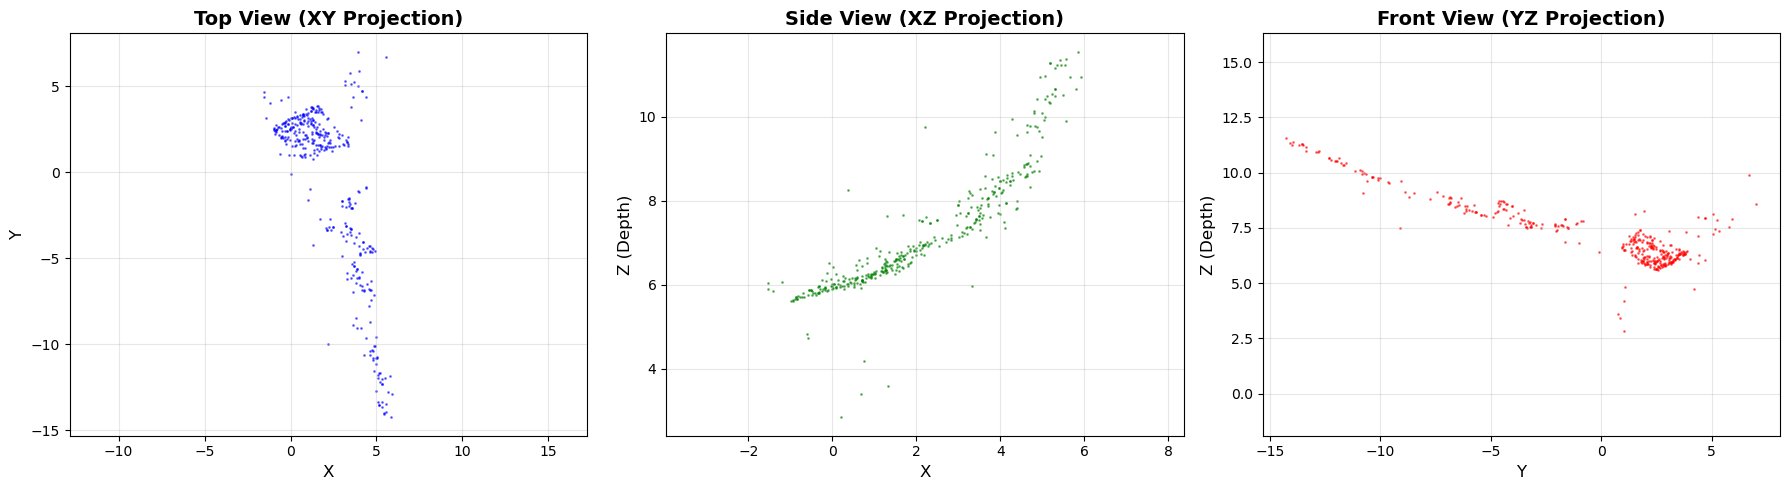

2D projection plot saved to: point_cloud_2d_projections.png


In [13]:
# === 2D scatter projection (XY, XZ, YZ views) ===

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# XY projection
axes[0].scatter(points_final[:, 0], points_final[:, 1], s=1, c='blue', alpha=0.5)
axes[0].set_xlabel('X', fontsize=12)
axes[0].set_ylabel('Y', fontsize=12)
axes[0].set_title('Top View (XY Projection)', fontsize=14, fontweight='bold')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# XZ projection
axes[1].scatter(points_final[:, 0], points_final[:, 2], s=1, c='green', alpha=0.5)
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('Z (Depth)', fontsize=12)
axes[1].set_title('Side View (XZ Projection)', fontsize=14, fontweight='bold')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

# YZ projection
axes[2].scatter(points_final[:, 1], points_final[:, 2], s=1, c='red', alpha=0.5)
axes[2].set_xlabel('Y', fontsize=12)
axes[2].set_ylabel('Z (Depth)', fontsize=12)
axes[2].set_title('Front View (YZ Projection)', fontsize=14, fontweight='bold')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('point_cloud_2d_projections.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"2D projection plot saved to: point_cloud_2d_projections.png")

## Step 11: Interactive 3D Visualization (Open3D + Jupyter Inline)

In [16]:
# === 3D visualization with Open3D  ===

# Create point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_final)

# Color the point cloud (light blue)
pcd.paint_uniform_color([0.2, 0.6, 1.0])

# Estimate normals for better visualization
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

print("\n" + "="*50)
print("=== 3D VISUALIZATION ===")
print("="*50)

# Option 1: Interactive Open3D Window (Desktop)
print("Opening interactive Open3D viewer window...")
print("Controls: Left-click=Rotate | Right-click=Pan | Scroll=Zoom | Q=Quit")

o3d.visualization.draw_geometries(
    [pcd],
    window_name="Two-View Reconstruction - 3D Point Cloud",
    width=1024,
    height=768,
    left=50,
    top=50
)

print("✅ Interactive window closed.")

# Option 2: Jupyter Inline Visualization (Renders in notebook)
print("\n📊 Rendering 3D point cloud inline in Jupyter...")

import plotly.graph_objects as go

# Extract point coordinates
points = np.asarray(pcd.points)

# Create interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=points[:, 2],  # Color by depth (Z)
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title="Depth (Z)")
    )
)])

fig.update_layout(
    title="3D Point Cloud - Two-View Reconstruction",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z (Depth)',
        aspectmode='data'
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

print("✅ Inline 3D visualization complete.")


=== 3D VISUALIZATION ===
Opening interactive Open3D viewer window...
Controls: Left-click=Rotate | Right-click=Pan | Scroll=Zoom | Q=Quit
✅ Interactive window closed.

📊 Rendering 3D point cloud inline in Jupyter...


✅ Inline 3D visualization complete.


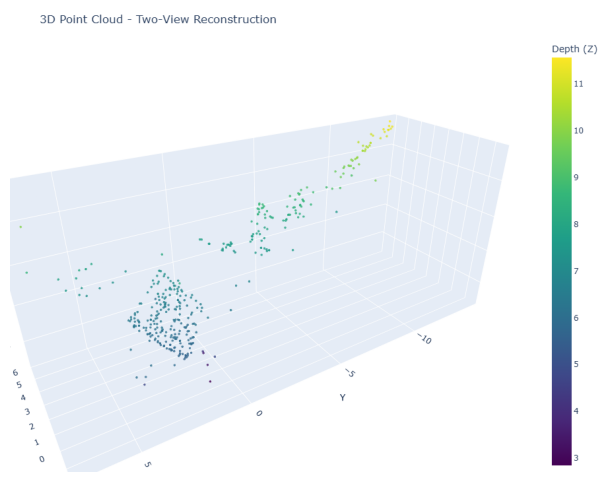

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(r"C:\Users\ASUS\Desktop\PROJECT\CV\newplot.png")
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.show()


## Step 12: Export Point Cloud to PLY Format

In [ ]:
# === Save point cloud to PLY file ===

output_path = os.path.join("two_view_reconstruction.ply")
o3d.io.write_point_cloud(output_path, pcd)

print("\n" + "="*50)
print("=== SAVED OUTPUT ===")
print("="*50)
print(f"✅ Point cloud saved to: {output_path}")
print(f"   File size: {os.path.getsize(output_path) / 1024:.2f} KB")
print(f"   Number of points: {len(pcd.points)}")


=== SAVED OUTPUT ===
✅ Point cloud saved to: two_view_reconstruction.ply
   File size: 19.33 KB
   Number of points: 383


## Step 13: Final Summary & Deliverable Report

In [ ]:
# === Final Summary ===

print("\n" + "="*60)
print("=" * 60)
print(" " * 15 + "WEEK 2 DELIVERABLE SUMMARY")
print("=" * 60)
print(f"\n Input Images:")
print(f"   Image 1: {os.path.basename(img1_path)}")
print(f"   Image 2: {os.path.basename(img2_path)}")
print(f"   Resolution: {w}×{h}")

print(f"\n Feature Matching:")
print(f"   Keypoints in Image 1: {len(kp1)}")
print(f"   Keypoints in Image 2: {len(kp2)}")
print(f"   Good matches (after Lowe's ratio test): {len(good)}")
print(f"   RANSAC inliers: {inlier_mask.sum()}")

print(f"\n Camera Parameters:")
print(f"   Intrinsic Matrix K:")
print(f"   fx = {K[0,0]:.2f}, fy = {K[1,1]:.2f}")
print(f"   cx = {K[0,2]:.2f}, cy = {K[1,2]:.2f}")

print(f"\n 3D Reconstruction:")
print(f"   Triangulated points: {points_3d.shape[0]}")
print(f"   After cheirality check: {points_valid.shape[0]}")
print(f"   After outlier removal: {points_final.shape[0]}")
print(f"   Final point cloud size: {points_final.shape[0]} points")

print(f"\n Output Files:")
print(f"    {output_path}")
print(f"    {os.path.join(frames_dir, 'point_cloud_2d_projections.png')}")


               WEEK 2 DELIVERABLE SUMMARY

 Input Images:
   Image 1: frame_0011.jpg
   Image 2: frame_0012.jpg
   Resolution: 1080×1920

 Feature Matching:
   Keypoints in Image 1: 2452
   Keypoints in Image 2: 3188
   Good matches (after Lowe's ratio test): 396
   RANSAC inliers: 386

 Camera Parameters:
   Intrinsic Matrix K:
   fx = 760.41, fy = 760.41
   cx = 540.00, cy = 960.00

 3D Reconstruction:
   Triangulated points: 386
   After cheirality check: 386
   After outlier removal: 383
   Final point cloud size: 383 points

 Output Files:
    two_view_reconstruction.ply
    C:\Users\ASUS\Desktop\PROJECT\CV\data\frames\point_cloud_2d_projections.png
